In [1]:
import numpy as np
import os
import pandas as pd
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10


# Initialize dicts.
auprc = {}
best_trials = {}
metrics = {}


# Loop over augmentations.
for aug_kind_str in ["all", "none"]:
    # Initialize dictionaries
    auprc_dict = {
        "validation": np.zeros((n_units, n_trials)),
        "test": np.zeros((n_units, n_trials))}
    best_trials_dict = {}
    metrics_dict = {
        "validation": {
            "TP": np.zeros((n_thresholds,)),
            "FP": np.zeros((n_thresholds,)),
            "FN": np.zeros((n_thresholds,))},
        "test-CV": {
            "TP": np.zeros((n_thresholds,)),
            "FP": np.zeros((n_thresholds,)),
            "FN": np.zeros((n_thresholds,))},
        "test-oracle": {
            "TP": np.zeros((n_thresholds,)),
            "FP": np.zeros((n_thresholds,)),
            "FN": np.zeros((n_thresholds,))}
    }
    
    
    # Define model directory
    model_name = "icassp-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)

    
    # Loop over test units.
    for test_unit_id, test_unit_str in enumerate(units):
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                test_auprc = 0.0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_p = np.array([1.0] + list(val_p) + [0.0])
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_r = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r, val_p, reorder=True)
                
                test_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                test_metrics_df = pd.read_csv(test_metrics_path)
                test_tp = np.array(test_metrics_df["True positives"])
                test_fp = np.array(test_metrics_df["False positives"])
                test_fn = np.array(test_metrics_df["False negatives"])
                
                test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
                test_p = np.array([1.0] + list(test_p) + [0.0])
                test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
                test_r = np.array([0.0] + list(test_r) + [1.0])
                test_auprc = sklearn.metrics.auc(test_r, test_p, reorder=True)
                
            auprc_dict["validation"][test_unit_id, trial_id] = val_auprc
            auprc_dict["test"][test_unit_id, trial_id] = test_auprc
            
            best_trials_dict["validation"] = np.argmax(auprc_dict["validation"], axis=1)
            best_trials_dict["test"] = np.argmax(auprc_dict["test"], axis=1)
         
        
        # Load prediction of trial maximizing validation accuracy.
        cv_trial_str = "trial-" +\
            str(best_trials_dict["validation"][test_unit_id])
        cv_metrics_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            cv_trial_str,
            "predict-" + test_unit_str,
            "full-audio-metrics.csv"
        ])
        cv_trial_dir = os.path.join(test_unit_dir, cv_trial_str)
        cv_metrics_path = os.path.join(cv_trial_dir, cv_metrics_name)
        cv_metrics_df = pd.read_csv(cv_metrics_path)
        
        # Update cross-validated test TP, FP, and FN.
        metrics_dict["test-CV"]["TP"] =\
            metrics_dict["test-CV"]["TP"] +\
            np.array(cv_metrics_df["True positives"])
        metrics_dict["test-CV"]["FP"] =\
            metrics_dict["test-CV"]["FP"] +\
            np.array(cv_metrics_df["False positives"])
        metrics_dict["test-CV"]["FN"] =\
            metrics_dict["test-CV"]["FN"] +\
            np.array(cv_metrics_df["False negatives"])

        
        # Load prediction of trial maximizing test accuracy.
        oracle_trial_str = "trial-" +\
            str(best_trials_dict["test"][test_unit_id])
        oracle_metrics_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            oracle_trial_str,
            "predict-" + test_unit_str,
            "full-audio-metrics.csv"
        ])
        oracle_trial_dir = os.path.join(test_unit_dir, oracle_trial_str)
        oracle_metrics_path = os.path.join(oracle_trial_dir, oracle_metrics_name)
        oracle_metrics_df = pd.read_csv(oracle_metrics_path)
        
        # Update oracle test TP, FP, and FN.
        metrics_dict["test-oracle"]["TP"] =\
            metrics_dict["test-oracle"]["TP"] +\
            np.array(oracle_metrics_df["True positives"])
        metrics_dict["test-oracle"]["FP"] =\
            metrics_dict["test-oracle"]["FP"] +\
            np.array(oracle_metrics_df["False positives"])
        metrics_dict["test-oracle"]["FN"] =\
            metrics_dict["test-oracle"]["FN"] +\
            np.array(oracle_metrics_df["False negatives"])
         
    metrics_dict["test-CV"]["TP"] = np.array(
        [1] + list(metrics_dict["test-CV"]["TP"]) + [1])
    metrics_dict["test-CV"]["FP"] = np.array(
        [0] + list(metrics_dict["test-CV"]["FP"]) + [sys.maxsize])
    metrics_dict["test-CV"]["FN"] = np.array(
        [sys.maxsize] + list(metrics_dict["test-CV"]["FN"]) + [0])

    metrics_dict["test-oracle"]["TP"] = np.array(
        [1] + list(metrics_dict["test-oracle"]["TP"]) + [1])
    metrics_dict["test-oracle"]["FP"] = np.array(
        [0] + list(metrics_dict["test-oracle"]["FP"]) + [sys.maxsize])
    metrics_dict["test-oracle"]["FN"] = np.array(
        [sys.maxsize] + list(metrics_dict["test-oracle"]["FN"]) + [0])


    # Measure test precision, recall, F1 and AUPRC in CV mode.
    metrics_dict["test-CV"]["Precision"] =\
        metrics_dict["test-CV"]["TP"] /\
        (np.finfo(float).eps +\
         metrics_dict["test-CV"]["TP"] + metrics_dict["test-CV"]["FP"])
    metrics_dict["test-CV"]["Recall"] =\
        metrics_dict["test-CV"]["TP"] /\
        (np.finfo(float).eps +\
         metrics_dict["test-CV"]["TP"] + metrics_dict["test-CV"]["FN"])
    metrics_dict["test-CV"]["F1 Score"] =\
        2*metrics_dict["test-CV"]["Precision"]*metrics_dict["test-CV"]["Recall"] /\
        (np.finfo(float).eps +\
         metrics_dict["test-CV"]["Precision"] + metrics_dict["test-CV"]["Recall"])
    metrics_dict["test-CV"]["AUPRC"] = sklearn.metrics.auc(
        metrics_dict["test-CV"]["Recall"],
        metrics_dict["test-CV"]["Precision"],
        reorder=True)
        
    
    # Measure test precision, recall, F1 and AUPRC in oracle mode.
    metrics_dict["test-oracle"]["Precision"] =\
        metrics_dict["test-oracle"]["TP"] /\
        (np.finfo(float).eps +\
         metrics_dict["test-oracle"]["TP"] + metrics_dict["test-oracle"]["FP"])
    metrics_dict["test-oracle"]["Recall"] =\
        metrics_dict["test-oracle"]["TP"] /\
        (np.finfo(float).eps +\
         metrics_dict["test-oracle"]["TP"] + metrics_dict["test-oracle"]["FN"])
    metrics_dict["test-oracle"]["F1 Score"] =\
        2*metrics_dict["test-oracle"]["Precision"]*metrics_dict["test-oracle"]["Recall"] /\
        (np.finfo(float).eps +\
         metrics_dict["test-oracle"]["Precision"] + metrics_dict["test-oracle"]["Recall"])
    metrics_dict["test-oracle"]["AUPRC"] = sklearn.metrics.auc(
        metrics_dict["test-oracle"]["Recall"],
        metrics_dict["test-oracle"]["Precision"],
        reorder=True)
        
        
    auprc[aug_kind_str] = auprc_dict
    best_trials[aug_kind_str] = best_trials_dict    
    metrics[aug_kind_str] = metrics_dict

In [ ]:
import h5py
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import sys
from tqdm import tqdm
sys.path.append('../src')
import localmodule


# Define directory of spectral flux ODFs.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
units = localmodule.get_units()
n_units = len(units)
sf_dir = os.path.join(data_dir,
    "_".join([dataset_name, "spectral-flux"]))


# Define constants.
sf_sr = 22050
sf_hop_length = 512
n_thresholds = 100
min_dist = 4
tolerance = 0.5


# Define array of thresholds.
thresholds = np.linspace(0.0, 0.5, n_thresholds)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


# Loop over units.
for unit_id, unit_str in enumerate(units):

    # Load onset detection function.
    odf_path = os.path.join(sf_dir, unit_str + ".hdf5")
    odf_file = h5py.File(odf_path, "r")
    odf = odf_file["spectral-flux_odf"].value
    odf = np.ravel(odf)
    odf_file.close()

    # Load annotation.
    annotation_path = os.path.join(
        annotations_dir, unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    # Loop over thresholds.
    for th_id, threshold in tqdm(enumerate(thresholds)):
        # Pick peaks.
        peak_locs = peakutils.indexes(
            odf, thres=threshold, min_dist=4)
        selected = peak_locs * sf_hop_length / sf_sr
        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)
        
        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, unit_id] = true_positives
        fp_matrix[th_id, unit_id] = false_positives
        fn_matrix[th_id, unit_id] = false_negatives
        
sf_total_tps = np.sum(tp_matrix, axis=1)
sf_total_fps = np.sum(fp_matrix, axis=1)
sf_total_fns = np.sum(fn_matrix, axis=1)

sf_total_precisions = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fps)
sf_total_precisions = sf_total_precisions[::-1]
sf_total_recalls = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fns)
sf_total_recalls = sf_total_recalls[::-1]
sf_total_f1_scores = (2*sf_total_precisions*sf_total_recalls) / (sf_total_precisions+sf_total_recalls)

100it [00:51, 18.80it/s]
5it [00:09,  1.98s/it]

In [2]:
models_dir = localmodule.get_models_dir()
model_name = "SKM"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)

unit_relevant = []
unit_selected, unit_tp = [], []
for unit_str in units:
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    precisions = np.array(df["precision (%)"])
    precisions = np.insert(precisions, 0, 0.0)
    precisions = np.append(precisions, 100)
    precisions = precisions[::-1] / 100
    recalls = np.array(df["recall (%)"])
    recalls = np.insert(recalls, 0, 100.0)
    recalls = np.append(recalls, 0.0)
    recalls = recalls[::-1] / 100
    unit_relevant.append(np.array(df["relevant"])[0])
    unit_selected.append(np.array(df["selected"]))
    unit_tp.append(np.array(df["true positives"]))
    

relevant = np.sum(np.array(unit_relevant))
selected = np.sum(np.stack(unit_selected), axis=0)
tp = np.sum(np.stack(unit_tp), axis=0)
precisions = tp / selected
recalls = tp / relevant
precisions = np.insert(precisions, 0, 0.0)
precisions = np.append(precisions, 1.0)
precisions = 100 * precisions[::-1]
recalls = np.insert(recalls, 0, 1.0)
recalls = np.append(recalls, 0.0)
recalls = 100 * recalls[::-1]

skm_precisions = precisions
skm_recalls = recalls
skm_f1_scores = 2*skm_precisions*skm_recalls / (skm_precisions+skm_recalls)

In [3]:
models_dir = localmodule.get_models_dir()
model_name = "oldbird"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)
prefix = "_".join([dataset_name, "oldbird_merged_clip-suppressor"])
n_thresholds = 100

unit_relevant = []
unit_selected, unit_tp = [], []

tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

for unit_id, unit_str in enumerate(units):
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([prefix, unit_str, tol_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    true_positives = np.array(df["True positives"])
    tp_matrix[:, unit_id] = true_positives
    false_positives = np.array(df["False positives"])
    fp_matrix[:, unit_id] = false_positives
    false_negatives = np.array(df["False negatives"])
    fn_matrix[:, unit_id] = false_negatives
    
    
oldbird_tp = np.sum(tp_matrix, axis=1)
oldbird_fp = np.sum(fp_matrix, axis=1)
oldbird_fn = np.sum(fn_matrix, axis=1)

eps = np.finfo(float).eps
oldbird_precisions = 100 * oldbird_tp / (eps+oldbird_tp+oldbird_fp)
oldbird_recalls = 100 * oldbird_tp / (eps+oldbird_tp+oldbird_fn)

sorting_indices = np.argsort(oldbird_recalls)
oldbird_precisions = oldbird_precisions[sorting_indices]
oldbird_recalls = oldbird_recalls[sorting_indices]

oldbird_f1_scores = 2*oldbird_precisions*oldbird_recalls / (eps+oldbird_precisions+oldbird_recalls)

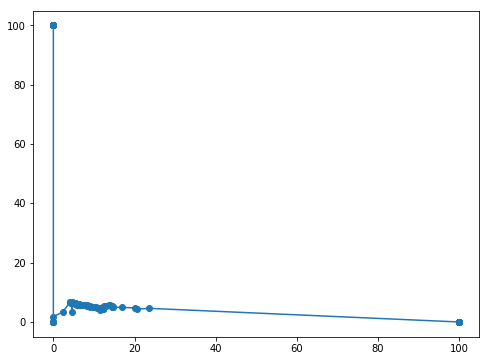

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))

oldbird_precisions = np.insert(oldbird_precisions, 0, 100.0)
oldbird_precisions = np.append(oldbird_precisions, 0.0)
oldbird_recalls = np.insert(oldbird_recalls, 0, 0.0)
oldbird_recalls = np.append(oldbird_recalls, 100.0)
oldbird_f1_score = np.max(oldbird_f1_scores)
oldbird_auprc = np.trapz(oldbird_precisions, oldbird_recalls) / 100
oldbird_label = "Old Bird. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    oldbird_f1_score, oldbird_auprc)
plt.plot(oldbird_recalls, oldbird_precisions, "-o", label=oldbird_label)

plt.savefig("ibac_fig1.eps")

#plt.title("Full night BirdVox-70k. Tolerance = {} ms.".format(tolerance_ms))
#plt.xlabel("Recall (%)")
#plt.ylabel("Precision (%)")
#plt.legend()

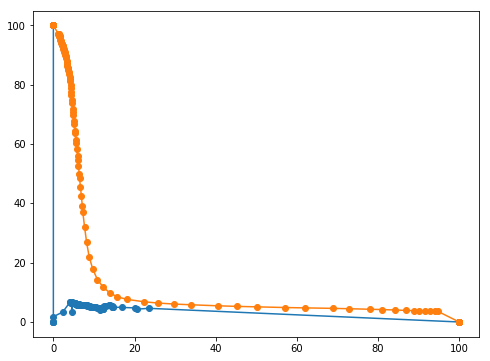

In [14]:
plt.figure(figsize=(8, 6))


oldbird_precisions = np.insert(oldbird_precisions, 0, 100.0)
oldbird_precisions = np.append(oldbird_precisions, 0.0)
oldbird_recalls = np.insert(oldbird_recalls, 0, 0.0)
oldbird_recalls = np.append(oldbird_recalls, 100.0)
oldbird_f1_score = np.max(oldbird_f1_scores)
oldbird_auprc = np.trapz(oldbird_precisions, oldbird_recalls) / 100
oldbird_label = "Old Bird. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    oldbird_f1_score, oldbird_auprc)
plt.plot(oldbird_recalls, oldbird_precisions, "-o", label=oldbird_label)


skm_precisions = np.insert(skm_precisions, 0, 100.0)
skm_precisions = np.append(skm_precisions, 0.0)
skm_recalls = np.insert(skm_recalls, 0, 0.0)
skm_recalls = np.append(skm_recalls, 100.0)
skm_f1_score = np.max(skm_f1_scores)
skm_auprc = np.trapz(skm_precisions, skm_recalls) / 100
skm_label = "SKM (out of set). F={:2.0f}%, AUPRC={:2.0f}%.".format(
    skm_f1_score, skm_auprc)
plt.plot(skm_recalls, skm_precisions, "-o", label=skm_label)

plt.savefig("ibac_fig2.eps")

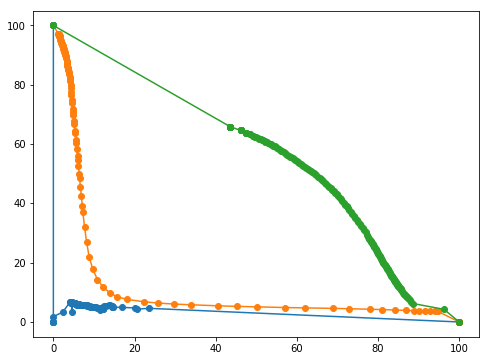

In [13]:
plt.figure(figsize=(8, 6))


oldbird_precisions = np.insert(oldbird_precisions, 0, 100.0)
oldbird_precisions = np.append(oldbird_precisions, 0.0)
oldbird_recalls = np.insert(oldbird_recalls, 0, 0.0)
oldbird_recalls = np.append(oldbird_recalls, 100.0)
oldbird_f1_score = np.max(oldbird_f1_scores)
oldbird_auprc = np.trapz(oldbird_precisions, oldbird_recalls) / 100
oldbird_label = "Old Bird. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    oldbird_f1_score, oldbird_auprc)
plt.plot(oldbird_recalls, oldbird_precisions, "-o", label=oldbird_label)


skm_precisions = np.insert(skm_precisions, 0, 100.0)
skm_precisions = np.append(skm_precisions, 0.0)
skm_recalls = np.insert(skm_recalls, 0, 0.0)
skm_recalls = np.append(skm_recalls, 100.0)
skm_f1_score = np.max(skm_f1_scores)
skm_auprc = np.trapz(skm_precisions, skm_recalls) / 100
skm_label = "SKM (out of set). F={:2.0f}%, AUPRC={:2.0f}%.".format(
    skm_f1_score, skm_auprc)
plt.plot(skm_recalls, skm_precisions, "-o", label=skm_label)


icassp_precisions = 100 * metrics["none"]["test-CV"]["Precision"]
icassp_recalls = 100 * metrics["none"]["test-CV"]["Recall"]
icassp_precisions = np.insert(icassp_precisions, 0, 100.0)
icassp_precisions = np.append(icassp_precisions, 0.0)
icassp_recalls = np.insert(icassp_recalls, 0, 0.0)
icassp_recalls = np.append(icassp_recalls, 100.0)
icassp_f1_scores = 2*icassp_precisions*icassp_recalls /\
    (np.finfo(float).eps+icassp_precisions+icassp_recalls)
icassp_f1_score = np.max(icassp_f1_scores)
icassp_auprc = np.trapz(icassp_precisions, icassp_recalls) / 100
icassp_label = "ICASSP convnet. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    icassp_f1_score, icassp_auprc)
plt.plot(icassp_recalls, icassp_precisions, "-o", label=icassp_label)


plt.savefig("ibac_fig3.eps")

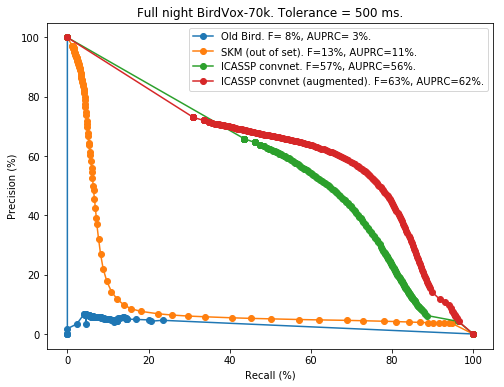

In [16]:
plt.figure(figsize=(8, 6))


oldbird_precisions = np.insert(oldbird_precisions, 0, 100.0)
oldbird_precisions = np.append(oldbird_precisions, 0.0)
oldbird_recalls = np.insert(oldbird_recalls, 0, 0.0)
oldbird_recalls = np.append(oldbird_recalls, 100.0)
oldbird_f1_score = np.max(oldbird_f1_scores)
oldbird_auprc = np.trapz(oldbird_precisions, oldbird_recalls) / 100
oldbird_label = "Old Bird. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    oldbird_f1_score, oldbird_auprc)
plt.plot(oldbird_recalls, oldbird_precisions, "-o", label=oldbird_label)


skm_precisions = np.insert(skm_precisions, 0, 100.0)
skm_precisions = np.append(skm_precisions, 0.0)
skm_recalls = np.insert(skm_recalls, 0, 0.0)
skm_recalls = np.append(skm_recalls, 100.0)
skm_f1_score = np.max(skm_f1_scores)
skm_auprc = np.trapz(skm_precisions, skm_recalls) / 100
skm_label = "SKM (out of set). F={:2.0f}%, AUPRC={:2.0f}%.".format(
    skm_f1_score, skm_auprc)
plt.plot(skm_recalls, skm_precisions, "-o", label=skm_label)


icassp_precisions = 100 * metrics["none"]["test-CV"]["Precision"]
icassp_recalls = 100 * metrics["none"]["test-CV"]["Recall"]
icassp_precisions = np.insert(icassp_precisions, 0, 100.0)
icassp_precisions = np.append(icassp_precisions, 0.0)
icassp_recalls = np.insert(icassp_recalls, 0, 0.0)
icassp_recalls = np.append(icassp_recalls, 100.0)
icassp_f1_scores = 2*icassp_precisions*icassp_recalls /\
    (np.finfo(float).eps+icassp_precisions+icassp_recalls)
icassp_f1_score = np.max(icassp_f1_scores)
icassp_auprc = np.trapz(icassp_precisions, icassp_recalls) / 100
icassp_label = "ICASSP convnet. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    icassp_f1_score, icassp_auprc)
plt.plot(icassp_recalls, icassp_precisions, "-o", label=icassp_label)


icassp_aug_precisions = 100 * metrics["all"]["test-CV"]["Precision"]
icassp_aug_recalls = 100 * metrics["all"]["test-CV"]["Recall"]
icassp_aug_precisions = np.insert(icassp_aug_precisions, 0, 100.0)
icassp_aug_precisions = np.append(icassp_aug_precisions, 0.0)
icassp_aug_recalls = np.insert(icassp_aug_recalls, 0, 0.0)
icassp_aug_recalls = np.append(icassp_aug_recalls, 100.0)
icassp_aug_f1_scores = 2*icassp_aug_precisions*icassp_aug_recalls /\
    (np.finfo(float).eps+icassp_aug_precisions+icassp_aug_recalls)
icassp_aug_f1_score = np.max(icassp_aug_f1_scores)
icassp_aug_auprc = np.trapz(icassp_aug_precisions, icassp_aug_recalls) / 100
icassp_aug_label = "ICASSP convnet (augmented). F={:2.0f}%, AUPRC={:2.0f}%.".format(
    icassp_aug_f1_score, icassp_aug_auprc)
plt.plot(icassp_aug_recalls, icassp_aug_precisions, "-o", label=icassp_aug_label)

plt.title("Full night BirdVox-70k. Tolerance = {} ms.".format(tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.legend()

#plt.savefig("ibac_fig4.eps")

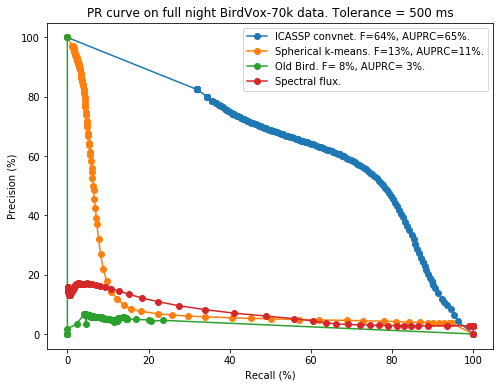

In [8]:


sf_precisions = np.insert(sf_total_precisions, 0, 100.0)
sf_precisions = np.append(sf_total_precisions, 0.0)
sf_recalls = np.insert(sf_total_recalls, 0, 0.0)
sf_recalls = np.append(sf_total_recalls, 100.0)
sf_label = "Spectral flux."
plt.plot(sf_recalls, sf_precisions, "-o", label=sf_label)


plt.title("PR curve on full night BirdVox-70k data. Tolerance = {} ms".format(tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.legend()

In [17]:
best_trials

{'all': {'test': array([5, 7, 2, 1, 9, 0]),
  'validation': array([7, 7, 2, 0, 3, 3])},
 'none': {'test': array([4, 5, 0, 7, 8, 6]),
  'validation': array([3, 0, 0, 7, 1, 2])}}

In [19]:
np.argmax(icassp_f1_scores)

82